<a href="https://colab.research.google.com/github/NupurFunkwal/Information_retrieval/blob/main/PA1_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Rohan Kumar 2018A7PS1013G
2. Nupur Funkwal 2018A7PS0624G
3. Isha Sethi 2018A7PS1017G
4. Yahu Bhatnagar 2018A7PS0789G



"documents.txt", "query.txt", "relevance_assessment.txt" and "query1.txt" to be uploaded through google.colab. Here "query1.txt" is the updated wildcard query file


In [ ]:

!pip install matplotlib
!pip install nltk
!pip install whoosh

from google.colab import files
uploaded = files.upload()

import functools
import matplotlib.pyplot as plt
import math
from whoosh import analysis
from nltk.stem.snowball import PorterStemmer,SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
import numpy as np

ps = PorterStemmer()
ls = LancasterStemmer()
ss = SnowballStemmer('english')

     |████████████████████████████████| 471kB 5.3MB/s 


Saving query1.txt to query1.txt
Saving query.txt to query.txt
Saving relevance_assessment.txt to relevance_assessment.txt
Saving documents.txt to documents.txt


#function definitions and class definitions


In [ ]:
#creates nodes

class DictNode:
  def __init__(self, doc):
    self.freq = 1;
    self.list_of_docs = [];
    self.list_of_docs.append(doc);


def insert_bag_of_words(words, bag_of_words, doc_id, type_of_index):
  for word in words:
    if type_of_index == 'R':
      word = ls.stem(word);
    if word != ' ' or word != '':
      if word.lower() in bag_of_words:
        if doc_id not in bag_of_words[word.lower()].list_of_docs:
          bag_of_words[word.lower()].list_of_docs.append(doc_id);
          bag_of_words[word.lower()].freq += 1;
      else:
        bag_of_words[word.lower()] = DictNode(doc_id);

#extracts relevant docs

def get_relevant_docs(relevant_docs):
   with open("/content/relevance_assessment.txt") as fp:
    counter = 0;
    key = "";
    for line in fp:
      if counter==0:
        counter+=1;
        continue;
      
      elif counter == 1:
        relevant_docs[line] = set();
        key = line;
        counter+=1;
        continue;
      
      elif counter == 2:
        docs = line.strip().rstrip("\n").split();
        relevant_docs[key] = set(docs);
        counter+=1;
      elif counter==3:
        counter=0;



#constructs I_full

def construct_I_full(bag_of_words,docsreq,type_of_index):
  with open("/content/documents.txt") as fp:
    doc = 1;
    for line in fp:
      if line == (str(doc+1)+"\n"):
        doc+=1;
        #print(doc);
        continue;
      else:
        if line == "   /\n":
          continue;
        if doc in docsreq:  
          insert_bag_of_words(line.rstrip("\n").strip().split(" "), bag_of_words, str(doc), type_of_index);
  if type_of_index == 'P':
    to_delete = [];
    for key in bag_of_words:
      if bag_of_words[key].freq>=25:  #Remove stopwords(If freq>=25, then stopword)
        to_delete.append(key);
    for key in to_delete:
      del bag_of_words[key];



#retrieve docs

def retrieve_docs(bag_of_words,retrieved_docs, relevant_docs, type_of_index, title):
  precision = [];
  recall = [];
  f_score = [];
  query_id = [];
  with open("/content/query.txt") as fp:
    counter = 0;
    key = "";
    for line in fp:
      if counter == 0:
        counter+=1;
        continue;
      elif counter==1:
        key = line;
        retrieved_docs[key] = set();
        counter+=1;
        continue;
      elif counter==2:
        query_words = line.strip().rstrip("\n").split();
        for term in query_words:
          if type_of_index == 'R':
            term = ls.stem(term);
          if term.lower() in bag_of_words:
            retrieved_docs[key] = retrieved_docs[key].union(set(bag_of_words[term.lower()].list_of_docs));
        print_performance(retrieved_docs, relevant_docs, key, precision, recall, f_score, query_id);
        counter+=1;
      elif counter==3:
        counter = 0;
        continue;
  plot_graph(precision, recall, f_score, query_id, title)


#prints performance

def print_performance(retrieved_docs, relevant_docs, key, precision, recall, f_score, query_id):
  true_positive = len(retrieved_docs[key].intersection(relevant_docs[key]));
  precision_quer = true_positive/len(retrieved_docs[key]);
  recall_quer = true_positive/len(relevant_docs[key]);
  f_score_quer = (2*precision_quer*recall_quer)/(precision_quer+recall_quer);
  query_id.append(int(key.rstrip("\n")));
  precision.append(round(precision_quer,2));
  recall.append(round(recall_quer,2));
  f_score.append(round(f_score_quer,2));


#wildcard queries performance

def print_performance_bigram(retrieved_docs, relevant_docs, key, precision, recall, f_score):
  if len(retrieved_docs) == 0 :
    precision.append(0);
    recall.append(0);
    f_score.append(-1)
    return
  true_positive = len(retrieved_docs.intersection(relevant_docs[key]));
  precision_quer = true_positive/len(retrieved_docs);
  recall_quer = true_positive/len(relevant_docs[key]);
  f_score_quer = (2*precision_quer*recall_quer)/(precision_quer+recall_quer);
  precision.append(round(precision_quer,2));
  recall.append(round(recall_quer,2));
  f_score.append(round(f_score_quer,2));


#plots graph

def plot_graph(precision, recall, f_score, query_id, title):
  width = 0.25;
  r1 = np.arange(1,len(query_id)+1)
  plt.xticks(r1);
  plt.bar(r1 - width,precision,width, label="precision");
  plt.bar(r1, f_score, width, label="Fscore");
  plt.bar(r1 + width,recall,width, label="recall");
  plt.xlabel("Query Id");
  plt.ylabel("Performance");
  plt.legend();
  plt.title(title);
  plt.show();


#extracts wildcard queries

def wildcard_query():
  file_name="query1.txt"  #query1.txt is edited for bigrams

  data = uploaded[file_name].decode("utf-8").split("\r\n")
  data.insert(0,'/')
  data.append('11')
  filter=[]
  for i in range(3,42,4):
    filter.append(data[i])

  queries=[x.lower() for x in filter]
  return queries


class BiGramNode:
  def __init__(self,term):
    self.list_of_terms=[]
    self.list_of_terms.append(term)


#constructs bigram index

def construct_bigram_index(bag_of_words, bigram_dict):
  from whoosh import analysis

  invert_terms=list(bag_of_words.keys())
  ana = analysis.NgramAnalyzer(2)

  for i in range(len(invert_terms)):
    word=invert_terms[i]
    word="$"+word+"$"
    bigrams_of_term=[token.text for token in ana(word)]
    for b in bigrams_of_term:
      if b in bigram_dict:
        if invert_terms[i] not in bigram_dict[b].list_of_terms:
          bigram_dict[b].list_of_terms.append(invert_terms[i])
      else:
        bigram_dict[b]=BiGramNode(invert_terms[i])


#retrieving the doc ids for a given bigram for bigram_dict
def find_bigram_docs(bigram, bigram_dict, bag_of_words):
  
  list_of_all=[]

  if bigram in bigram_dict:
    for i in (bigram_dict[bigram].list_of_terms):
      for j in (bag_of_words[i].list_of_docs):
        if j not in list_of_all:
          list_of_all.append(j)

  return (list_of_all)


def Union(lst1, lst2): 
    final_list = lst1 + lst2 
    return final_list 

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


#returns wildcard query docs

def retrieve_wd_docs(bag_of_words, queries, query_wise_docs, bigram_dict):

  for i in range(len(queries)):
    ana = analysis.KeywordAnalyzer()
    ana_bi= analysis.NgramAnalyzer(2)
    query_tokens= [token.text for token in ana(queries[i])]  #making tokens for a query
    wildcard= [x for x in query_tokens if '*' in x]           #filtering out the wildcard tokens
    normal_tokens= [x for x in query_tokens if '*' not in x]   

    final_docs=[]     # contains union of all docs by union of each token
    for tkn in normal_tokens:
      if tkn in (bag_of_words.keys()):
        final_docs= Union(bag_of_words[tkn].list_of_docs,final_docs)
        break
                        

    for nt in normal_tokens:
      if nt in (bag_of_words.keys()):
        docs_for_given_token= bag_of_words[nt].list_of_docs
        final_docs= Union(final_docs, docs_for_given_token)


    for w in wildcard:
      term= "$"+w+"$"
      bi_of_wildcard=[token.text for token in ana_bi(term)]
      bi_of_wildcard= [z for z in bi_of_wildcard if "*" not in z]

      each_bigram_docs=find_bigram_docs(bi_of_wildcard[0], bigram_dict, bag_of_words)

      for bi_g in bi_of_wildcard:
        each_bigram_docs= intersection(each_bigram_docs,bi_g)

      #do union with final_docs for a given query
      final_docs= Union(final_docs, each_bigram_docs)

    query_wise_docs.append(final_docs)
    



#Main function

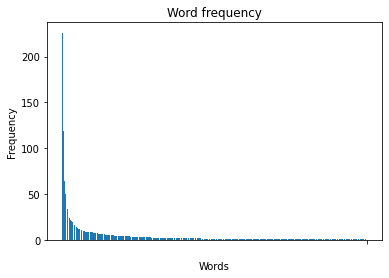



Vocabulary size of I_full= 2000
Vocabulary size of I_P= 1954
Vocabulary size of I_R= 1283




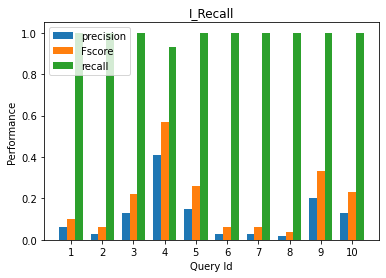

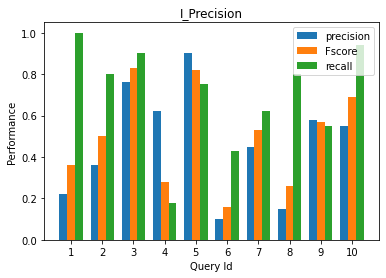

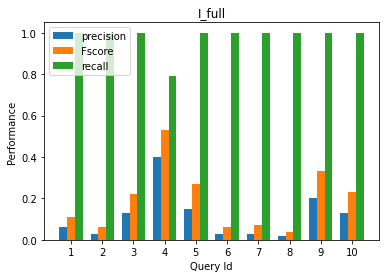

I_full bigram


Precision values
[0.06, 0.03, 0.13, 0.38, 0.15, 0.03, 0.03, 0.02, 0.19, 0.13]
Recall values
[1.0, 1.0, 1.0, 0.71, 0.97, 1.0, 1.0, 1.0, 0.98, 1.0]
Fscore values
[0.11, 0.06, 0.22, 0.5, 0.26, 0.06, 0.07, 0.04, 0.32, 0.23]


I_P bigram


Precision values
[0.24, 0.5, 0.79, 0, 0.87, 0.1, 0.5, 0.11, 0.53, 0.65]
Recall values
[1.0, 0.4, 0.76, 0, 0.56, 0.43, 0.25, 0.4, 0.43, 0.94]
Fscore values
[0.38, 0.44, 0.77, -1, 0.68, 0.17, 0.33, 0.17, 0.47, 0.77]


I_R bigram


Precision values
[0.06, 0.03, 0.11, 0.35, 0.15, 0.03, 0.03, 0.02, 0.19, 0.13]
Recall values
[1.0, 1.0, 0.9, 0.55, 0.97, 1.0, 0.88, 1.0, 0.96, 1.0]
Fscore values
[0.11, 0.06, 0.2, 0.43, 0.26, 0.06, 0.06, 0.04, 0.32, 0.23]


In [ ]:

def main():
  relfile = open("/content/relevance_assessment.txt",'r')
  docsreq = []
  i=0
  docslines = [3,7,11,15,19,23,27,31,35,39]
  for line in relfile:
    i=i+1
    if i in docslines:
      docnos = line.split()
      for docno in docnos:
        if int(docno) in docsreq:
          continue;
        docsreq.append(int(docno));
  
  relevant_docs = {};
  get_relevant_docs(relevant_docs);


  filepath = "/content/documents.txt";
  #task 1
  I_full = {}; #dictionary task1
  construct_I_full(I_full,docsreq,'N');
  I_full_copy = I_full.copy();
  I_full_copy = sorted(I_full_copy.items(), key = lambda x:x[1].freq, reverse=True);
  words_bar = [];
  freq_bar = [];
  for key in I_full_copy:
    words_bar.append(key[0])
    freq_bar.append(key[1].freq);
  plt.bar(words_bar, freq_bar);
  plt.ylabel("Frequency");
  plt.xlabel("Words");
  plt.xticks(" ");
  plt.title("Word frequency")
  plt.show();
  
  print("\n")
  print("Vocabulary size of I_full=",len(I_full))

  #task2
  I_P = {}; 
  construct_I_full(I_P,docsreq,'P');
  print("Vocabulary size of I_P=",len(I_P))

  I_R = {};
  construct_I_full(I_R,docsreq,'R');
  print("Vocabulary size of I_R=",len(I_R))
  print("\n")

  retrieved_docs = {};
  retrieve_docs(I_R, retrieved_docs, relevant_docs,'R', "I_Recall");

  retrieved_docs = {};
  retrieve_docs(I_P, retrieved_docs, relevant_docs,'P', "I_Precision");

  retrieved_docs = {};
  retrieve_docs(I_full, retrieved_docs, relevant_docs,'N', "I_full");

  #task4
  bigram_dict_full = {}
  construct_bigram_index(I_full,bigram_dict_full)

  bigram_dict_P = {}
  construct_bigram_index(I_P,bigram_dict_P)

  bigram_dict_R = {}
  construct_bigram_index(I_R,bigram_dict_R)

  queries = wildcard_query();
  query_wise_docs = [];
  retrieve_wd_docs(I_full, queries, query_wise_docs, bigram_dict_full);
  
  precision_bigram = []
  recall_bigram = []
  f_score_bigram = []
  for i in range (10):
    retrieved_docs_bigram = set(query_wise_docs[i]);
    key = str(i+1)+"\n"
    print_performance_bigram(retrieved_docs_bigram, relevant_docs, key, precision_bigram, recall_bigram, f_score_bigram)
  print("I_full bigram")
  print("\n")
  print("Precision values")
  print(precision_bigram)
  print("Recall values")
  print(recall_bigram)
  print("Fscore values")
  print(f_score_bigram)
  print("\n")

  query_wise_docs.clear();
  retrieve_wd_docs(I_P, queries, query_wise_docs, bigram_dict_P);
  
  precision_bigram.clear()
  recall_bigram.clear()
  f_score_bigram.clear()
  for i in range (10):
    retrieved_docs_bigram = set(query_wise_docs[i]);
    key = str(i+1)+"\n"
    print_performance_bigram(retrieved_docs_bigram, relevant_docs, key, precision_bigram, recall_bigram, f_score_bigram)
    
  print("I_P bigram")
  print("\n")
  print("Precision values")
  print(precision_bigram)
  print("Recall values")
  print(recall_bigram)
  print("Fscore values")
  print(f_score_bigram)
  print("\n")

  query_wise_docs.clear();
  retrieve_wd_docs(I_R, queries, query_wise_docs, bigram_dict_R);
  
  precision_bigram.clear()
  recall_bigram.clear()
  f_score_bigram.clear()
  for i in range (10):
    retrieved_docs_bigram = set(query_wise_docs[i]);
    key = str(i+1)+"\n"
    print_performance_bigram(retrieved_docs_bigram, relevant_docs, key, precision_bigram, recall_bigram, f_score_bigram)
    
  print("I_R bigram")
  print("\n")
  print("Precision values")
  print(precision_bigram)
  print("Recall values")
  print(recall_bigram)
  print("Fscore values")
  print(f_score_bigram)



main();

#Task 1
1.   Size of vocabulary in I_full = 2000

#Task 2
1.   Size of vocabulary in I_P = 1954
2.   Size of vocabulary in I_R = 1283

#Task 3:

a)For increasing the recall for I_R, stemming was used and stopwords were kept. Since stopwords were kept, recall was already high but with stemming, slight change was there in the recall of query 4. For all other queries recall was 1.0. Porter, Lancaster, Snowball stemmers were tried with Lancaster stemmer giving the best results. Therefore Lancaster stemmer was used.

For increasing the precision for I_P, stopwords were removed as lot of irrelevant documents were getting retrieved. All words with frequency>=25 were removed. Different values were tried but 25 gave the best F-score. Therefore 25 was used as a threshold.

b)(i)After removing stopwords precision of I_P is much greater than precision of  I_full as can be seen in the graph.

(ii)After using Lancaster stemmer, recall for query 4 increased but recall for all other queries remained the same(1.0).

(iii)Precision of I_P is higher than I_R and recall of I_R is greater than I_P as can be seen in the graph. But I_P is a better model overall since its F-score is better than I_R. 


#Task 4:
(i)I_full_bigram and I_R_bigram performed nearly the same with very little change in precision, but recall values were slightly higher in I_full_bigram. F-score was almost the same for both. 

(ii)I_P_bigram had a better precision than I_R_bigram and I_full_bigram and recall is lesser than both. Although the F-score is highest for I_P_bigram among all 3 models.

(iii)I_P_bigram has the best F-score value since removal of stopwords increases the precision by a lot but does not reduce the recall much. This was seen in task 3 as well.